In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
import joblib
%matplotlib inline

np.random.seed(3)
tf.random.set_seed(3)

## Dataset setting

In [ ]:
pre = pd.read_csv('kd_data.csv')

pre_df = pd.DataFrame(pre)

pre_df

,person_id,gender,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,...,Malignant neoplastic disease,Chronic liver disease,chronic obstructive lung disease,cerebrovascular disease,chronic kidney disease,Diabetes mellitus,Ischemic heart disease,hyperlipidemia,Hypertensive disorder,cancer
0,1673221,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1289235,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1690134,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,530465,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,737827,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,1756845,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405,14298,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
406,1646575,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
407,352251,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pre_df.columns = ['person_id','gender', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_7', 'age_8', 'smoking_status_0.0', 'smoking_status_1.0',
       'smoking_status_2.0', 'smoking_status_3.0', 'bmi_1.0', 'bmi_2.0', 'bmi_3.0',
       'bmi_4.0', 'Malignant_neoplastic_disease', 'Chronic_liver_disease',
       'chronic_obstructive_lung_disease', 'cerebrovascular_disease',
       'chronic_kidney_disease', 'Diabetes_mellitus', 'Ischemic_heart_disease',
       'hyperlipidemia', 'Hypertensive_disorder', 'cancer']

pre_df = pre_df.astype('int64')

In [ ]:
# The process of separating layers and features, shuffling them, and creating batches using batch_size.
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('cancer')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)

    return ds

## Train/Test data split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(pre_df, test_size=0.3, random_state=3, stratify=pre_df['cancer'])

In [ ]:
train_ds= df_to_dataset(train, batch_size=len(train),shuffle=False)
test_ds= df_to_dataset(test, batch_size=len(test),shuffle=False)
all_ds = df_to_dataset(pre_df, batch_size=len(pre_df),shuffle=False)

In [ ]:
print(Counter(pre_df['cancer']))

Counter({0: 320, 1: 89})


In [ ]:
X_train, x_test, Y_train, y_test = train_test_split(pre_df.iloc[:,1:27],pre_df['cancer'], test_size=0.3, stratify=pre_df['cancer'],random_state=3)

In [ ]:
x_data = pre_df.iloc[:,1:27]
y_data = pre_df['cancer']

## Class Weight

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(Y_train),y=Y_train)

class_weights

array([0.63839286, 2.30645161])

In [ ]:
class_weights = {0:class_weights[0], 1:class_weights[1]}

## Model Load

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

In [ ]:
from sklearn import metrics
from tensorflow.keras.layers import Input,Dense,SimpleRNN, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L1, L2,L1L2
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC curve

### SVM, Random Forest

In [ ]:
clf_labels = ['SVM','Random Forest']

pred = []

for label in clf_labels:
    model = joblib.load(label+'.pkl') # Loading a saved model.
    model = model.fit(X_train,Y_train)
    real_pred = model.predict(x_data)
    real_pred = [ 1 if x >= 0.5 else 0 for x in real_pred]
    pred.append(real_pred)

### DNN

In [ ]:
[(_, train_label)] = train_ds.take(1)
[(_, test_label)] = test_ds.take(1)
[(_, all_label)] = all_ds.take(1)

In [ ]:
DNN = joblib.load('DNN.pkl')

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
DNN.compile(optimizer=Adam(learning_rate=0.005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [ ]:
history = DNN.fit(train_ds, epochs=100,callbacks=[early_stopping],class_weight = class_weights)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['person_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 3s 3s/step - loss: 0.4241 - tp: 47.0000 - fp: 41.0000 - tn: 183.0000 - fn: 15.0000 - accuracy: 0.8042 - precision: 0.5341 - recall: 0.7581 - auc: 0.8875 - prc: 0.6938
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 1.6622 - tp: 24.0000 - fp: 11.0000 - tn: 213.0000 - fn: 38.0000 - accuracy: 0.8287 - precision: 0.6857 - recall: 0.3871 - auc: 0.7697 - prc: 0.5894
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 0.4197 - tp: 50.0000 - fp: 37.0000 - tn: 187.0000 - fn: 12.0000 - accuracy: 0.8287 - precision: 0.5747 - recall: 0.8065 - auc: 0.8869 - prc: 0.7003
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.5545 - tp: 60.0000 - fp: 110.0000 - tn: 114.0000 - fn: 2.0000 - accuracy: 0.6084 - precision: 0.3529 - recall: 0.9677 - auc: 0.8494 - prc: 0.6053
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 0.5454 - tp: 58.0000 - fp: 122.0000 - tn: 102.0000 - fn: 4.000

In [ ]:
real_pred = DNN.predict(all_ds)
real_pred = [ 1 if x >= 0.5 else 0 for x in real_pred]
pred.append(real_pred)

1/1 [==============================] - 1s 918ms/step


In [ ]:
kd_data = np.array(pred)
print(kd_data.shape)

kd_data = np.transpose(kd_data)
print(kd_data.shape)

(3, 409)
(409, 3)


## KD Ensemble Model

In [ ]:
em_train, em_test = train_test_split(kd_data, test_size=0.3, random_state=3)

In [ ]:
em_test = pd.DataFrame(em_test, columns=['SVM','RF','DL'])
em_test

,SVM,RF,DL
0,0,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,0
...,...,...,...
118,1,1,1
119,1,1,0
120,0,0,0
121,0,0,0


In [ ]:
em_train_y , em_test_y = train_test_split(pre_df['cancer'], test_size=0.3, random_state=3)
em_train_y = np.array(em_train_y)

In [ ]:
model = Sequential()
model.add(Dense(32,activation="relu",  input_dim=3))
model.add(Dropout(0.01))
model.add(Dense(16,activation="relu", kernel_regularizer=L2(0.01)))
model.add(Dense(10,activation="relu", kernel_regularizer=L2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=0.005),loss='binary_crossentropy',metrics=METRICS)

In [ ]:
history = model.fit(em_train, em_train_y,epochs=100,batch_size=64, validation_split = 0.3,
                         verbose=2,callbacks=[early_stopping])

Epoch 1/100
4/4 - 2s - loss: 0.9896 - tp: 86.0000 - fp: 55.0000 - tn: 322.0000 - fn: 23.0000 - accuracy: 0.8395 - precision: 0.6099 - recall: 0.7890 - auc: 0.8690 - prc: 0.6947 - val_loss: 0.8749 - val_tp: 10.0000 - val_fp: 7.0000 - val_tn: 65.0000 - val_fn: 4.0000 - val_accuracy: 0.8721 - val_precision: 0.5882 - val_recall: 0.7143 - val_auc: 0.7460 - val_prc: 0.4757 - 2s/epoch - 572ms/step
Epoch 2/100
4/4 - 0s - loss: 0.8591 - tp: 35.0000 - fp: 21.0000 - tn: 132.0000 - fn: 12.0000 - accuracy: 0.8350 - precision: 0.6250 - recall: 0.7447 - auc: 0.7285 - prc: 0.5217 - val_loss: 0.7682 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 14.0000 - val_accuracy: 0.8372 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7207 - val_prc: 0.4667 - 76ms/epoch - 19ms/step
Epoch 3/100
4/4 - 0s - loss: 0.7708 - tp: 25.0000 - fp: 16.0000 - tn: 137.0000 - fn: 22.0000 - accuracy: 0.8100 - precision: 0.6098 - recall: 0.5319 - auc: 0.7374 - prc: 0.5717 - val_loss: 0.6922

In [ ]:
en_pred = model.predict(em_test)

4/4 [==============================] - 0s 2ms/step


In [ ]:
en_pred = [ 1 if x[0] >= 0.5 else 0 for x in en_pred]

In [ ]:
confusion_matrix(em_test_y,en_pred,labels=[1,0])

array([[22,  6],
       [10, 85]])

In [ ]:
print(classification_report(em_test_y,en_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        95
           1       0.69      0.79      0.73        28

    accuracy                           0.87       123
   macro avg       0.81      0.84      0.82       123
weighted avg       0.88      0.87      0.87       123



In [ ]:
print(classification_report(em_test_y,en_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89        95
           1       0.60      0.86      0.71        28

    accuracy                           0.84       123
   macro avg       0.78      0.84      0.80       123
weighted avg       0.87      0.84      0.85       123



In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(em_test_y, en_pred) #곡선 그리기
score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

0.893421052631579


### PR-CURVE

In [ ]:
from sklearn.metrics import precision_recall_curve
# svm
precision_svm, recall_svm,_ = precision_recall_curve(y_test,svm_pred)

# random forest
precision_rf, recall_rf,_ = precision_recall_curve(y_test,rf_pred)

# dnn
precision_dnn, recall_dnn,_ = precision_recall_curve(y_test,dnn_pred)

# ensemble
precision_em, recall_em, thresholds = precision_recall_curve(em_test_y, en_pred)

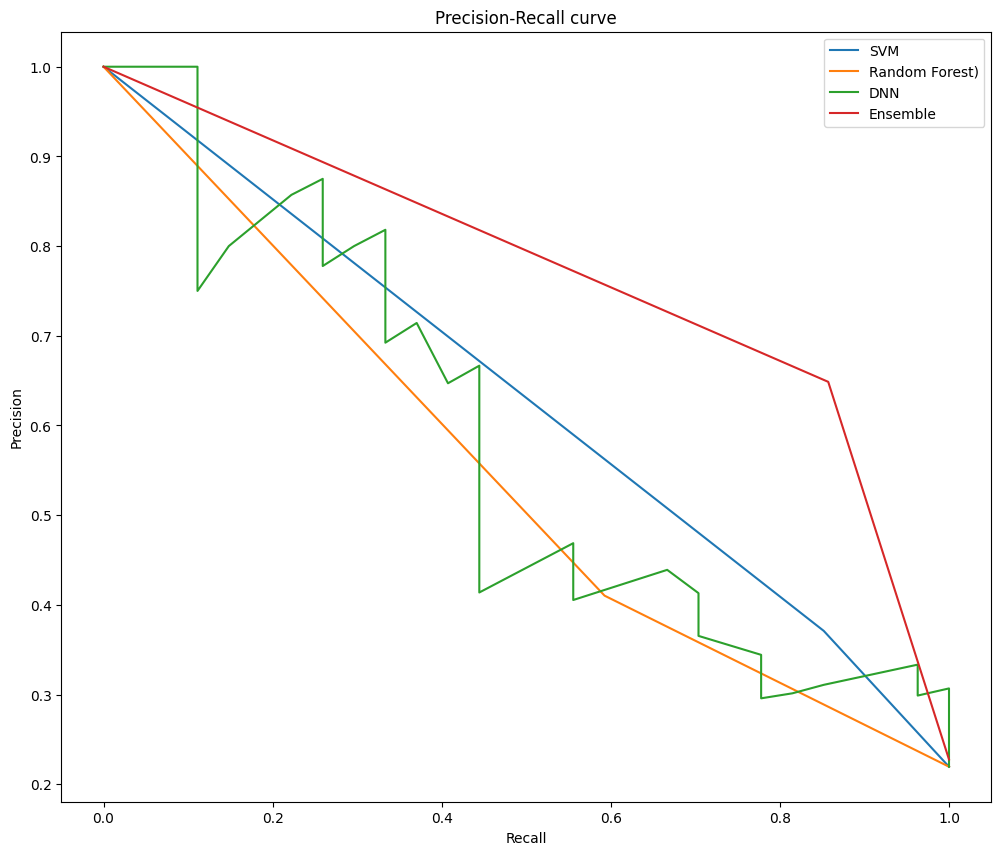

In [ ]:
plt.plot(recall_svm, precision_svm, label='SVM')
plt.plot(recall_rf, precision_rf, label='Random Forest)')
plt.plot(recall_dnn, precision_dnn, label='DNN')
plt.plot(recall_em, precision_em, label='Ensemble')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

## SHAP

In [ ]:
! git clone https://github.com/shap/shap.git

Cloning into 'shap'...
remote: Enumerating objects: 15324, done.
remote: Counting objects: 100% (3608/3608), done.
remote: Compressing objects: 100% (621/621), done.
remote: Total 15324 (delta 3272), reused 3033 (delta 2987), pack-reused 11716
Receiving objects: 100% (15324/15324), 281.98 MiB | 26.40 MiB/s, done.
Resolving deltas: 100% (10690/10690), done.
Updating files: 100% (488/488), done.


In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()
import matplotlib.pyplot as plt

### Ensemble

In [ ]:
p_list = pre_df['person_id']
em_train_id , em_test_id = train_test_split(p_list, test_size=0.3, random_state=3)

In [ ]:
result = pd.DataFrame([list(em_test_id), en_pred, en_pred1])

In [ ]:
result = result.T
result.columns=['ID','Proba','Pred']

In [ ]:
y = em_test_y.reset_index()

In [ ]:
result = pd.concat([result, em_test], axis=1)

In [ ]:
explainer = shap.KernelExplainer(model = model.predict, data=em_train, link="logit")

9/9 [==============================] - 0s 2ms/step


In [ ]:
shap_values = explainer.shap_values(em_test)

  0%|          | 0/123 [00:00<?, ?it/s]

54/54 [==============================] - 0s 1ms/step


In [ ]:
shap_values[0][61] # 62번째 환자 값

array([0.21149209, 0.30926967, 0.92616998])

In [ ]:
em_test.loc[61,:]

SVM    1
RF     1
DL     1
Name: 61, dtype: int64

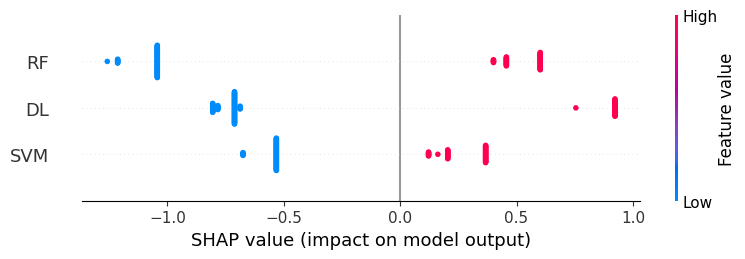

In [ ]:
plt.figure()
shap.summary_plot(shap_values[0], em_test)
plt.draw()
plt1 = plt.gcf()
#plt.savefig('graph_kd/en_shap_summary.png',dpi=600,bbox_inches='tight')
plt.close()

In [ ]:
def make_plot(ids): # 환자의 id로 shap result plot 확인 가능
    index = result.index[result['ID'] == ids]
    plt.figure()
    shap.force_plot(explainer.expected_value, shap_values[0][index], em_test.loc[index,:],matplotlib=True)
   # plt.savefig('graph_kd/en_shap_'+str(ids)+'.png',dpi=600,bbox_inches='tight')
    plt.close()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

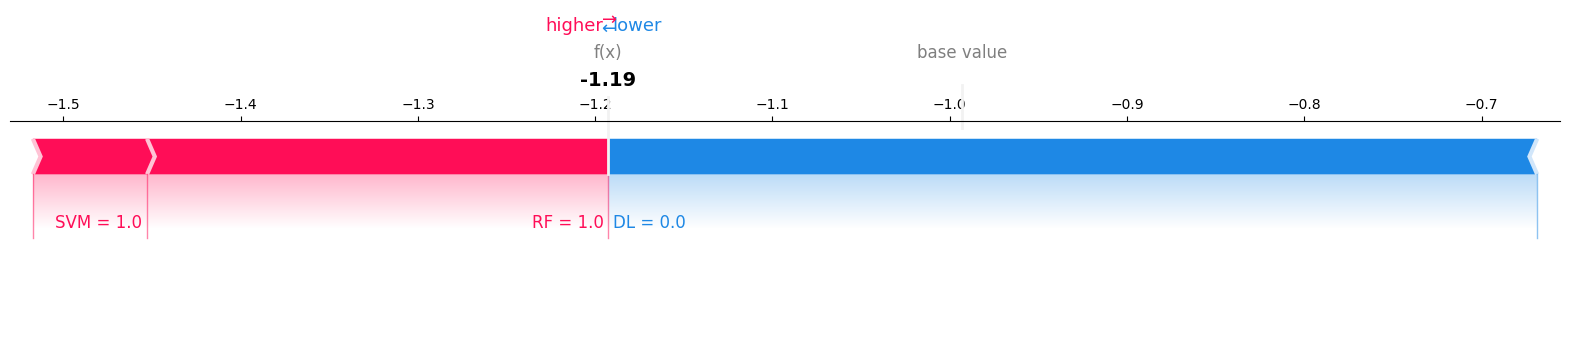

In [ ]:
make_plot(1637999)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], em_test, link="logit")

### SVM

In [ ]:
svm = joblib.load('SVM.pkl')
svm = svm.fit(X_train,Y_train)

svm_explainer = shap.KernelExplainer(model = svm.predict, data=X_train)
shap_values = svm_explainer.shap_values(x_test)

  0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
svm_explainer = shap.KernelExplainer(model = svm.predict, data=X_train)
shap_values = svm_explainer.shap_values(x_test)

  0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
shap_values[0]

array([ 0.15310524,  0.        ,  0.0566429 ,  0.01560455,  0.0140796 ,
       -0.01684772,  0.00409974,  0.        ,  0.        , -0.03126811,
        0.03093045,  0.        ,  0.01741074,  0.00142794, -0.00199096,
        0.        ,  0.0314747 ,  0.        ,  0.01117997,  0.01856157,
        0.02839882,  0.        ,  0.02134713,  0.01392386,  0.02686797,
        0.12603061])

In [ ]:
def make_svm_plot(ids):
    index = result.index[result['ID'] == ids]
    plt.figure()
    shap.force_plot(svm_explainer.expected_value, shap_values[index], x_test.iloc[index,:],matplotlib=True, text_rotation=17)
    plt.draw()
    plt1 = plt.gcf()
    #plt.savefig('graph_kd/svm_shap_'+str(ids)+'.png',dpi=600,bbox_inches='tight')
    plt.close()

<Figure size 640x480 with 0 Axes>

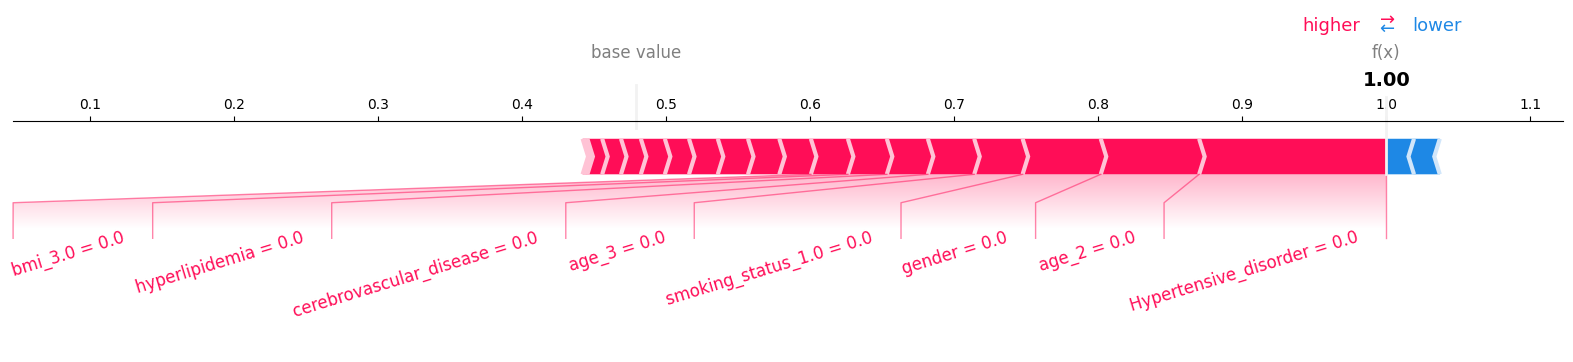

In [ ]:
make_svm_plot(158337)

### Random Forest

In [ ]:
rf = joblib.load('Random Forest.pkl')
rf = rf.fit(X_train,Y_train)

rf_explainer = shap.KernelExplainer(model = rf.predict, data=X_train)
shap_values = rf_explainer.shap_values(x_test)

  0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
shap_values[0]

array([ 0.14916852,  0.        ,  0.0546938 ,  0.08010586,  0.0327646 ,
       -0.01266288,  0.00525452, -0.00328228,  0.00037614, -0.00824047,
        0.02976135,  0.        ,  0.01782383,  0.        , -0.00400289,
       -0.01674386,  0.00749529,  0.        ,  0.00299193,  0.01996403,
        0.02958954,  0.00107688,  0.0207005 ,  0.013104  ,  0.02454677,
        0.1289414 ])

In [ ]:
def make_rf_plot(ids):
    index = result.index[result['ID'] == ids]
    plt.figure()
    shap.force_plot(rf_explainer.expected_value, shap_values[index], x_test.iloc[index,:],matplotlib=True, text_rotation=17)
    plt.draw()
    plt1 = plt.gcf()
    #plt.savefig('graph_kd/rf_shap_'+str(ids)+'.png',dpi=600,bbox_inches='tight')
    plt.close()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

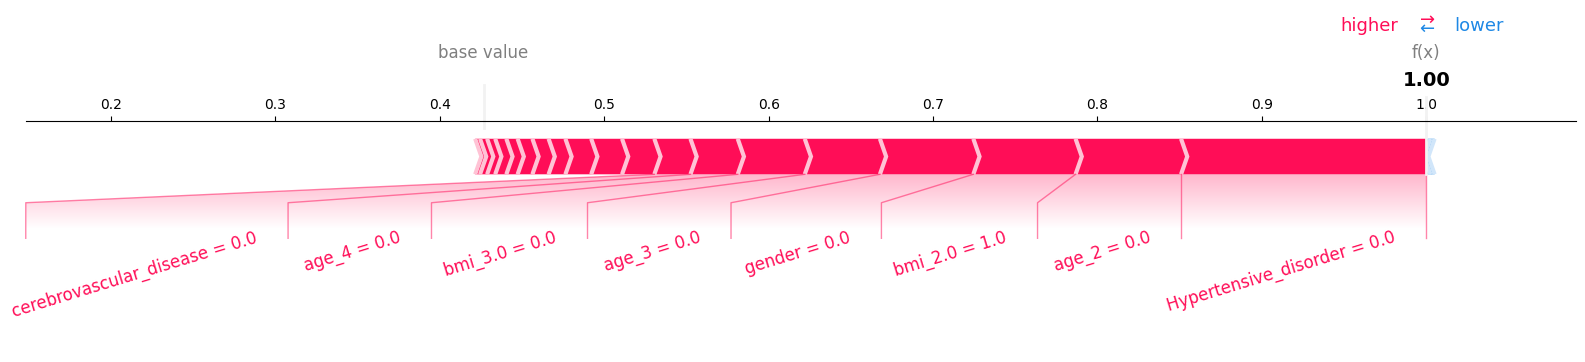

In [ ]:
make_rf_plot(158337)